In [24]:
import liana as li
import scanpy as sc
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import scipy

In [4]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"

In [2]:
# Display available methods in the liana package for ligand-receptor analysis
# This shows the implemented computational methods that can be applied within liana.
li.mt.show_methods()


,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


In [7]:
adata = sc.read_h5ad(f'{base_data_path}/adata_cluster_1-DEGs.h5ad')
adata

AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type', 'cnv_leiden', 'cnv_score', 'PLAUR_Status_Binary', '_scvi_raw_norm_scaling'
    var: 'n_cells', 'chromosome', 'start', 'end'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [8]:
# Run CellPhoneDB analysis on single-cell data with specified parameters
# This function identifies ligand-receptor interactions based on cell types in the dataset.

cellphonedb(
    adata,                  # Single-cell AnnData object containing expression data
    groupby='cell_type',    # Column in adata.obs that specifies cell types
    expr_prop=0.1,          # Minimum proportion of cells expressing a gene in each group to be considered
    verbose=True,           # Provides detailed logs of the process
    key_added='cpdb_res'    # Key to store CellPhoneDB results within adata
)


Using `.raw`!


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/liana/method/_pipe_utils/_pre.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


0.08 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 73580 samples and 26811 features


100%|██████████| 1000/1000 [00:55<00:00, 18.16it/s]


In [11]:
# Run CellPhoneDB analysis on the single-cell data
cellphonedb(
    adata,                      # Your AnnData object containing the single-cell data
    groupby='cell_type',        # Column in adata.obs to group cells by cell type
    resource_name='consensus',  # Use the 'consensus' resource; default uses HUMAN gene symbols
    expr_prop=0.1,              # Minimum expression proportion threshold
    verbose=True,               # Enable detailed logging
    key_added='cpdb_res'        # Key to store the results in adata.uns
)


Using `.raw`!


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/liana/method/_pipe_utils/_pre.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


0.08 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 73580 samples and 26811 features


100%|██████████| 1000/1000 [01:00<00:00, 16.56it/s]


In [12]:
# Check the type of the results stored in 'cpdb_res'
print(type(adata.uns['cpdb_res']))


<class 'pandas.core.frame.DataFrame'>


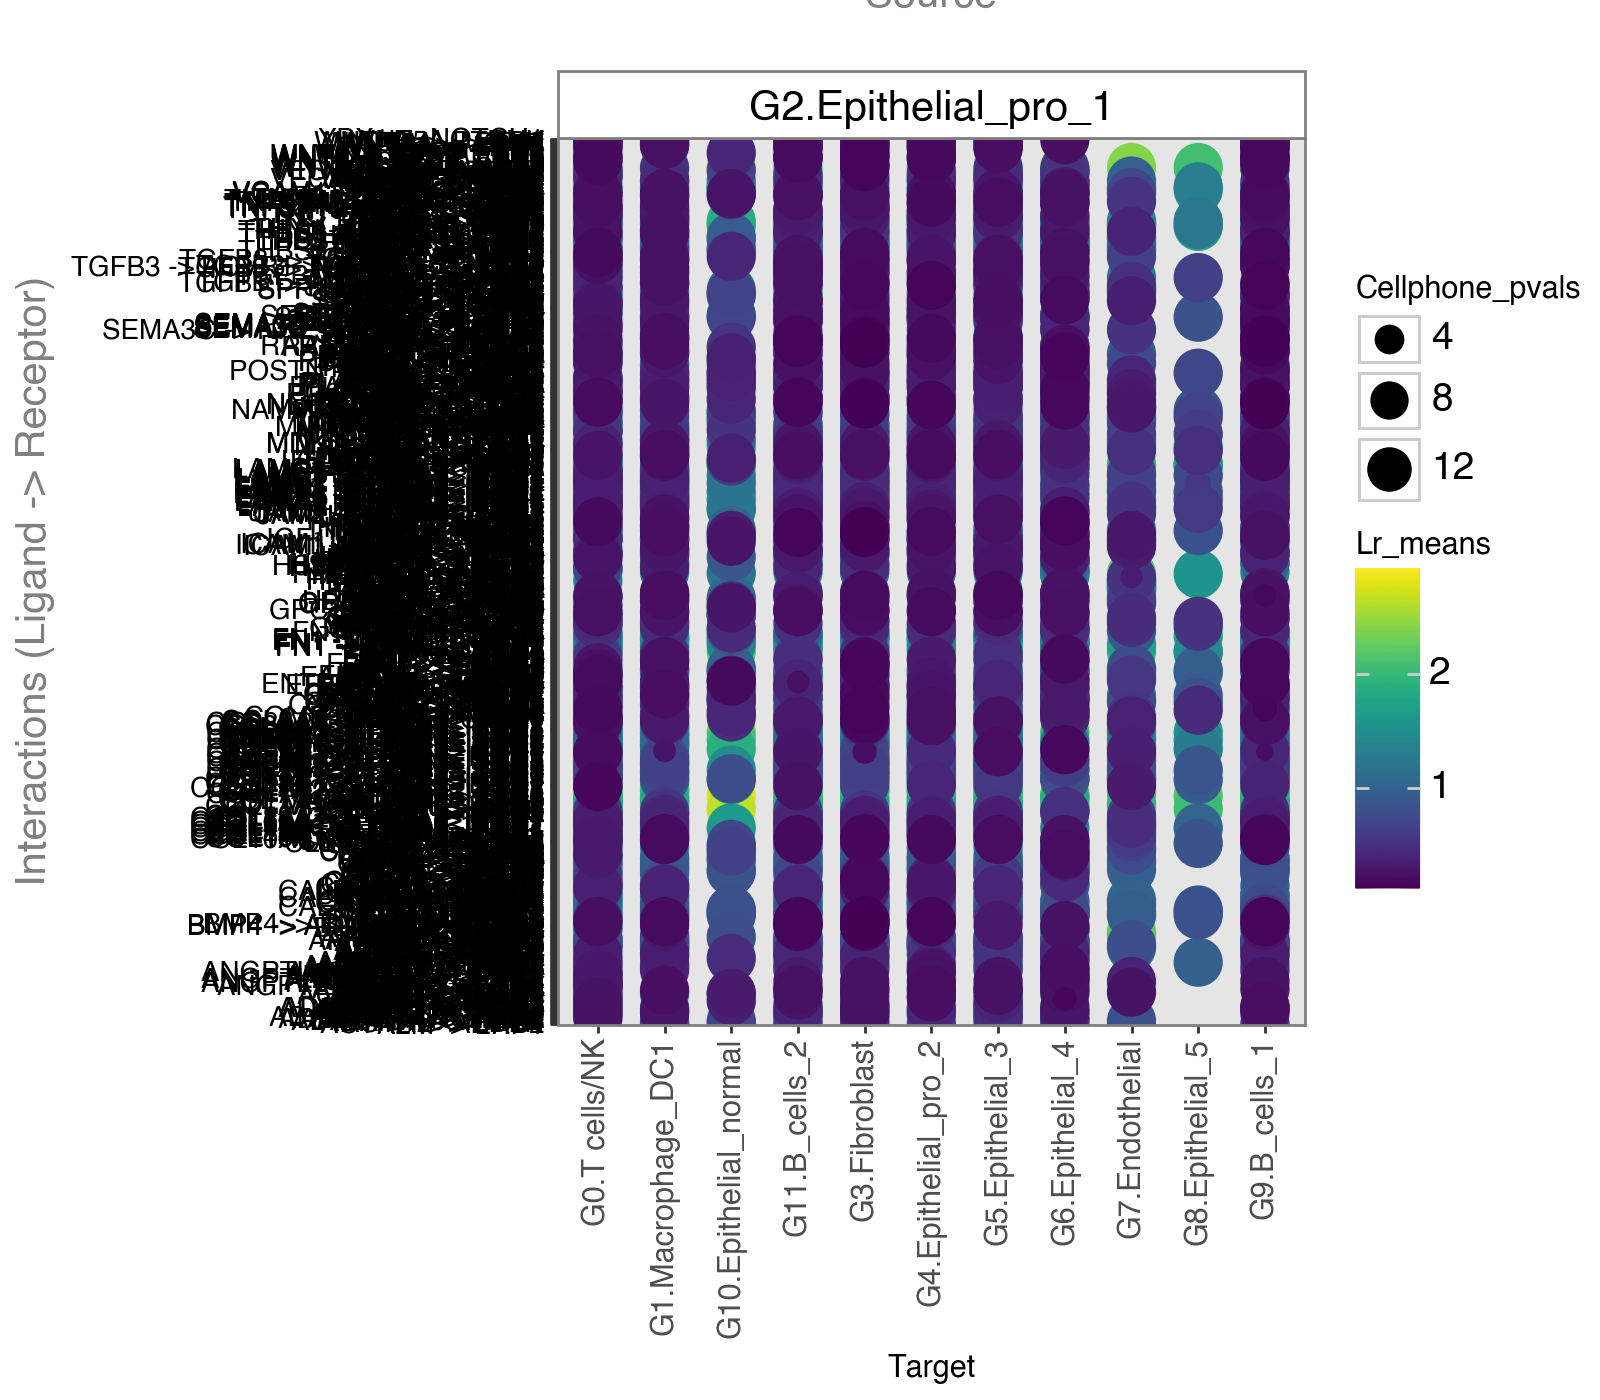

In [14]:
# Filter the CellPhoneDB results for significant interactions before plotting
# Access the relevant DataFrame from adata.uns['cpdb_res']
cpdb_results = adata.uns['cpdb_res']

# Filter the interactions for p-values ≤ 0.05
filtered_results = cpdb_results[cpdb_results['cellphone_pvals'] <= 0.05]

# Store the filtered results back in adata.uns if needed
adata.uns['cpdb_res_filtered'] = filtered_results

# Now, plot the filtered results using liana's dotplot function
li.pl.dotplot(
    adata=adata,                            # AnnData object with filtered results stored
    colour='lr_means',                      # Color dots by ligand-receptor interaction means
    size='cellphone_pvals',                 # Size dots by p-values
    inverse_size=True,                      # Invert dot size for smaller p-values to appear larger
    source_labels=["G2.Epithelial_pro_1"],  # Source cell type(s) for ligand-receptor interactions
    target_labels=[                         # Target cell types for ligand-receptor interactions
        "G0.T cells/NK", "G1.Macrophage_DC1", "G3.Fibroblast", "G4.Epithelial_pro_2",
        "G5.Epithelial_3", "G6.Epithelial_4", "G7.Endothelial", "G8.Epithelial_5",
        "G9.B_cells_1", "G10.Epithelial_normal", "G11.B_cells_2"
    ],
    figure_size=(8, 7),                     # Define figure size
    uns_key='cpdb_res_filtered'             # Use the key with filtered results
)


In [19]:
import liana
print(liana.__version__)


0.1.9


In [20]:
%pip install liana==1.0.4

ERROR: Ignored the following versions that require a different python version: 1.0.1 Requires-Python >=3.8,<3.12; 1.0.2 Requires-Python >=3.8,<3.12; 1.0.3 Requires-Python >=3.8,<3.12; 1.0.4 Requires-Python >=3.8,<3.12; 1.0.5 Requires-Python >=3.8,<3.12; 1.1.0 Requires-Python <3.12,>=3.8; 1.2.0 Requires-Python <3.12,>=3.8; 1.2.1 Requires-Python <3.12,>=3.8; 1.3.0 Requires-Python <3.12,>=3.8; 1.4.0 Requires-Python <3.12,>=3.8
ERROR: Could not find a version that satisfies the requirement liana==1.0.4 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.1.4, 0.1.5, 0.1.6, 0.1.7, 0.1.8, 0.1.9)
ERROR: No matching distribution found for liana==1.0.4

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
cell_types = {
    "G0.T cells/NK",
    "G1.Macrophage_DC1",
    "G2.Epithelial_pro_1",
    "G3.Fibroblast",
    "G4.Epithelial_pro_2",
    "G5.Epithelial_3",
    "G6.Epithelial_4",
    "G7.Endothelial",
    "G8.Epithelial_5",
    "G9.B_cells_1",
    "G10.Epithelial_normal",
    "G11.B_cells_2"
}


In [21]:
# # Generate a tile plot to visualize the top ligand-receptor interactions
# my_plot = li.pl.tileplot(
#     adata=adata,                          # AnnData object containing the interaction data
#     fill='means',                         # Specifies the data used to fill tile colors (mean expression values)
#     label='props',                        # Labels tiles with proportions or other metric
#     label_fun=lambda x: f'{x:.2f}',       # Formats labels to show two decimal places for clarity
#     top_n=10,                             # Displays the top 10 interactions based on specified ordering
#     orderby='cellphone_pvals',            # Orders tiles by p-values (useful for highlighting significance)
#     orderby_ascending=True,               # Sorts p-values in ascending order (most significant interactions first)

#     # Source and target cell types to specify the directionality of interactions
#     source_labels=["G2.Epithelial_pro_1"], # Specifies source cell type(s) for ligands
#     target_labels=[                        # Specifies target cell type(s) for receptors
#         "G0.T cells/NK", 
#         "G1.Macrophage_DC1", 
#         "G3.Fibroblast", 
#         "G7.Endothelial", 
#         "G9.B_cells_1", 
#         "G11.B_cells_2"
#     ],

#     uns_key='cpdb_res',                   # The key in adata.uns where CellPhoneDB results are stored (default is 'liana_res')
#     source_title='Ligand',                # Title for the source cells (ligand side)
#     target_title='Receptor',              # Title for the target cells (receptor side)
#     figure_size=(8, 7)                    # Figure size in inches (width, height) for readability
# )

# # Display the plot
# my_plot


In [30]:
# Convert the main matrix adata.X to dense if it’s sparse
if isinstance(adata.X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
    adata.X = adata.X.toarray()

# Convert any layers to dense, if present
for layer in adata.layers:
    if isinstance(adata.layers[layer], (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
        adata.layers[layer] = adata.layers[layer].toarray()

# Convert matrices in adata.obsm and adata.obsp to dense, if any
for key in adata.obsm:
    if isinstance(adata.obsm[key], (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
        adata.obsm[key] = adata.obsm[key].toarray()

for key in adata.obsp:
    if isinstance(adata.obsp[key], (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
        adata.obsp[key] = adata.obsp[key].toarray()

# Run rank aggregation after ensuring all matrices are dense
li.mt.rank_aggregate(
    adata=adata,                        # AnnData object containing single-cell data and interaction results
    groupby='cell_type',                # Column in adata.obs used to group cells by cell type
    resource_name='consensus',          # Specifies the interaction resource to use (e.g., 'consensus')
    expr_prop=0.1,                      # Minimum expression proportion threshold (10%)
    verbose=True                        # Enables verbose output for progress tracking
)


Using `.raw`!


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/liana/method/_pipe_utils/_pre.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


0.08 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 73580 samples and 26811 features


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/liana_env/lib/python3.12/site-packages/liana/method/_liana_pipe.py:312: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!


AttributeError: 'SparseCSRView' object has no attribute 'A'